In [27]:
%load_ext autoreload
%autoreload 2
import sys
if "../.." not in sys.path:
    sys.path.append("../..")

import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from scipy.optimize import minimize


import signature.signature.tensor_algebra as ta

from simulation.diffusion import Diffusion

import matplotlib
my_green = "#5b6c64"
my_copper = "#B56246"
plt.rcParams["figure.figsize"]        = ((1 + jnp.sqrt(5)) / 2 * 5, 5)
plt.rcParams["figure.autolayout"]     = True
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams["axes.grid"]             = True
plt.rcParams['axes.prop_cycle']       = matplotlib.cycler(color=[my_green, my_copper, "#322B4D", "#28BC9C", "#71074E"]) 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Goal: Model stationary path-dependence

Our goal is to develop a tool for which would allow us efficiently treat general stationary path-dependent models. By a **stationary path-dependence** we will understand the dependence
$$
S_t = F((X_s)_{-\infty < s \leq t}),
$$
such that 
\begin{equation}
    F((x_s)_{-\infty < s \leq t}) = F((x_{s - h})_{-\infty < s \leq t + h}).
\end{equation}
This means that $S_t$ depends only on the past path of $X$, but not on the time variable $t$ itself.


##### Generating the underlying Brownian motion:

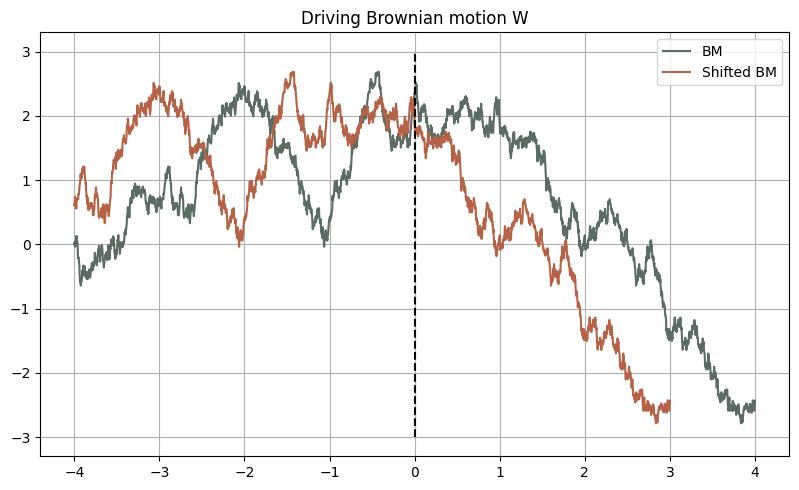

In [28]:
T = 4

t_grid = jnp.linspace(-T, T, (T * 2) * 365 + 1)
rng = np.random.default_rng(seed=50)
size = 10

diffusion = Diffusion(t_grid=t_grid - t_grid[0], size=size, rng=rng)
W = diffusion.brownian_motion()[0, 0, :]

fig, ax = plt.subplots()

shift = 365
ax.plot(t_grid, W, label="BM")
ax.plot(t_grid[:-shift], W[shift:], label="Shifted BM")
ax.vlines(0, -3, 3, "k", ls='--')
ax.legend()
ax.set_title("Driving Brownian motion W")

fig.tight_layout()
# fig.savefig("shifted_signal.pdf", format="pdf", transparent=True)

We denote the shifted (green) trajectory by $\widetilde W = (W_{t +1})_{t \in \mathbb{R}}$.

The condition of stationary path-dependence implies that $F((\widetilde W)_{s \leq 3}) = F((W)_{s \leq 4})$.

### Stationary Signature definition

The stationarity assumption is natural for many applications. However, it cannot be applied to the standard signature models. Indeed, the definition  of $\mathbb{X}_t$ can be seen as a Taylor expansion of path in the neighborhood of the time origin $t = 0$. 
- The presence of this time origin $t_0 = 0$ makes the stationaryty condition inapplicable due to the finiteness and variability of its length $t$. 
- Hence, it is natural to suppose that at time $t$, the path is observable from infinitely distant time $-\infty$ to $t$.

For the integrals to be defined, we damp the integrators $\circ dX_u$ by $e^{-\lambda(t - u)}$ for some positive $\lambda > 0$:

$$
	\mathbb{X}^{\lambda, n}_{t}= \int_{-\infty < u_{1} < \ldots < u_{n} < t}^{}  e^{ -\lambda(t-u_{1}) }\otimes \circ dX_{u_{1}} \ldots e^{ -\lambda(t-u_{n}) }\otimes \circ dX_{u_{n}} 
$$

The **stationary signature** is then given by $\mathbb{X}^{\lambda}_{t} = \left(\mathbb{X}^{\lambda, n}_{t}\right)_{n \geq 0}.$

Similarly, we can define
$$
	\mathbb{X}^{\lambda, n}_{s, t}= \int_{s < u_{1} < \ldots < u_{n} < t}^{}  e^{ -\lambda(t-u_{1}) }\otimes \circ dX_{u_{1}} \ldots e^{ -\lambda(t-u_{n}) }\otimes \circ dX_{u_{n}} 
$$
and $\mathbb{X}^{\lambda}_{s, t} = \left(\mathbb{X}^{\lambda, n}_{s, t}\right)_{n \geq 0}.$

### Computing the stationary signature for $\hat W_t = (t, W_t)$

- It is important to observe the signal for $t < 0$ for the signature on $[0, T]$ to be stationary.
- In practice, we take the path on $[T_0, T]$ for some $T_0 < 0$, compute the stationary signature $\widehat{\mathbb{W}}^{\lambda}_{t}$ and keep its values only for $t > 0$.

In [32]:
t_grid_pos = t_grid[t_grid >= 0]
W_pos = W[t_grid >= 0]

path = np.vstack([t_grid, W]).T
path_pos = np.vstack([t_grid_pos, W_pos]).T
dim = path.shape[1]

path.shape

(2921, 2)

In [30]:
%%time
N = 5
lam = 10
Sig = ta.path_to_signature(path=path_pos, trunc=N)

CPU times: total: 125 ms
Wall time: 135 ms


In [31]:
%%time
SigS = ta.path_to_stationary_signature(path=path, trunc=N, t_grid=t_grid, lam=lam)

CPU times: total: 812 ms
Wall time: 1.51 s


### Some nice properties

- The words ${\color{NavyBlue}{\mathbf{2}}}^{\otimes k}$ correspond to $\frac{Y_{t}^{k}}{k!}$, where $Y$ is a stationary OU process defined by $Y_{t} = \int_{-\infty}^{t} e^{ -\lambda(t-s) } \, dW_{s}$.
-  The words ${\color{NavyBlue}{\mathbf{1}}}^{\otimes k}$ correspond to constants $\frac{\lambda^{-k}}{k!}$.
-  The words ${\color{NavyBlue}{\mathbf{21} ... \mathbf{1}}}$ can be interpreted as an exponential moving averages of $Y$ with different coefficients $k\lambda$.

In [11]:
# Define some basic words
e = ta.AlgebraBasis(trunc=N, dim=dim)

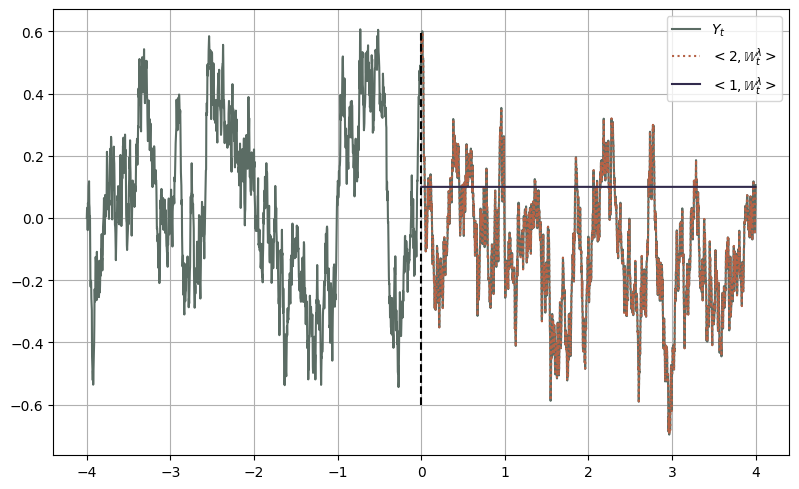

In [12]:
ou = diffusion.ornstein_uhlenbeck(lam=lam, theta=0, sigma=1)[0, 0, :]

fig, ax = plt.subplots()
ax.plot(t_grid, ou, label="$Y_t$")
ax.plot(t_grid_pos, e[2] @ SigS, ":", label="$<2, {\mathbb{W}}_{t}^{\lambda}>$")
ax.plot(t_grid_pos, e[1] @ SigS, label="$<1, {\mathbb{W}}_{t}^{\lambda}>$")
ax.legend()
ax.vlines(0, -0.6, 0.6, "k", ls='--')

### More properties


An operator $\mathcal{G}\colon T((\mathbb{R}^d)) \to T((\mathbb{R}^d))$ is defined by 
$$
\mathcal{G}\colon \boldsymbol{\ell} = (\boldsymbol{\ell}^n)_{n\geq 0} \mapsto \mathcal{G}\boldsymbol{\ell} = (n\boldsymbol{\ell}^n)_{n\geq 0}.
$$

For $\lambda > 0$ and $h \geq 0$, we define an operator $\mathcal{D}_h^\lambda$ by
\begin{align}
    \mathcal{D}_h^\lambda \colon\ & T((\mathbb{R}^d)) \to T((\mathbb{R}^d)) \\
    & \boldsymbol{\ell} = (\boldsymbol{\ell}^n)_{n \geq 0} \mapsto \mathcal{D}_h^\lambda \boldsymbol{\ell} = (e^{-n\lambda h}\boldsymbol{\ell}^n)_{n \geq 0}.
\end{align}

- Stationary signature satisfies the following SDE: $$
    d\mathbb{X}^{\lambda}_{t} = -\lambda \mathcal{G} \mathbb{X}^{\lambda}_{t}\,dt + \mathbb{X}^{\lambda}_{t}\otimes\circ dX_t.$$
- Chen's identity: $$ \mathbb{X}^{\lambda}_{s, t} = \mathcal{D}_{t - u}^\lambda\mathbb{X}^{\lambda}_{s, u} \otimes \mathbb{X}^{\lambda}_{u, t}.$$
- Shuffle property: $$\left\langle{ \boldsymbol{\ell},\, \widehat{\mathbb{W}}_{t}^{\lambda} }\right\rangle \left\langle{ \boldsymbol{\psi},\, \widehat{\mathbb{W}}_{t}^{\lambda} }\right\rangle =\left\langle{ \boldsymbol{\ell}\mathrel{\sqcup \mkern -3.2mu \sqcup} \boldsymbol{\psi},\, \widehat{\mathbb{W}}_{t}^{\lambda} }\right\rangle.$$
- Expected signature $\mathcal{E}^\lambda = \mathbb{E}\mathbb{X}^{\lambda}_{t}$ can be calculated explicitly, $\mathcal{E}_t^\lambda = \mathbb{E}\mathbb{X}^{\lambda}_{0, t}$ can be computed as a solution of ODE.

### Regression of coefficients

We want to estimate $\boldsymbol{\ell}$ observing a signal $S$, which is supposed to be a linear combination
$$S_t = \left\langle{ \boldsymbol{\ell},\, \widehat{\mathbb{W}}_{t}^{\lambda} }\right\rangle$$

As an example, we consider $S_t = \sin(Z_t)$, where 
$$
dZ_t = \kappa (\theta - Z_t) dt + \nu dW_t,
$$
and do the linear regression of $S_t$ against $\mathbb{W}_{t}^{\lambda}$.

Text(0.5, 1.0, 'Signal')

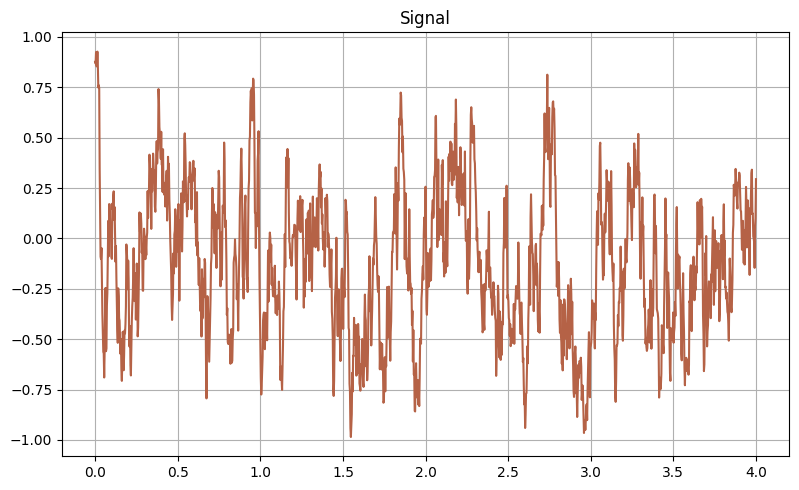

In [33]:
kappa = 25
theta = 0.
nu = 3

ou_mu = diffusion.ornstein_uhlenbeck(lam=kappa, theta=theta, sigma=nu)[0, 0, :]
signal = np.sin(ou_mu)[t_grid >= 0]

fig, ax = plt.subplots()
ax.plot(t_grid_pos, signal, color=my_copper)
ax.set_title("Signal")

In [34]:
trunc = 5
n_params = 2**(trunc + 1) - 1
eps_sig = 5e-5
eps_sigs = 0

in_sample_T = 1
in_sample_idx = (t_grid_pos <= in_sample_T)

def loss_vol_sig(l):
    vol_coef = ta.from_array(array=l, trunc=trunc, dim=dim)
    return np.mean((signal - Sig @ vol_coef)[in_sample_idx]**2) + eps_sig * np.sum(np.abs(l))

def loss_vol_stat_sig(l):
    vol_coef = ta.from_array(array=l, trunc=trunc, dim=dim)
    return np.mean((signal - SigS @ vol_coef)[in_sample_idx]**2) + eps_sigs * np.sum(np.abs(l))

l0 = jnp.zeros(n_params)

In [35]:
%%time
res = minimize(fun=loss_vol_sig, x0=l0)

CPU times: total: 1min 48s
Wall time: 3min 2s


In [36]:
%%time
res_stat = minimize(fun=loss_vol_stat_sig, x0=l0)

CPU times: total: 3.14 s
Wall time: 5.34 s


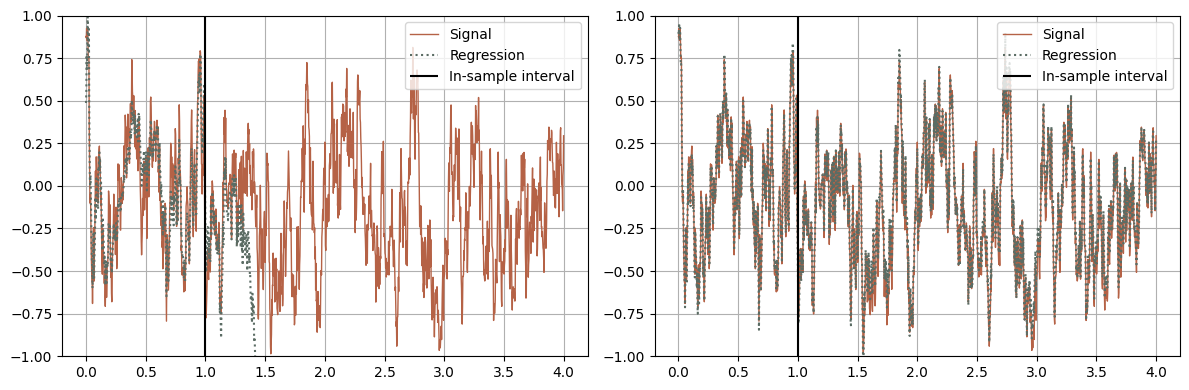

In [37]:
l_reg = ta.from_array(array=res.x, trunc=N, dim=dim)
l_reg_stat = ta.from_array(array=res_stat.x, trunc=N, dim=dim)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(t_grid_pos, signal, color=my_copper, lw=1, label="Signal")
ax[0].plot(t_grid_pos, Sig @ l_reg, ":", color=my_green,  label="Regression")
ax[0].vlines(x=in_sample_T, ymin=-1, ymax=1, color="k", label="In-sample interval")
ax[0].set_ylim([-1, 1])
#ax[0].set_title("Signature regression")
ax[0].legend()

ax[1].plot(t_grid_pos, signal, color=my_copper, lw=1, label="Signal")
ax[1].plot(t_grid_pos, SigS @ l_reg_stat, ":", color=my_green, label="Regression")
ax[1].vlines(x=in_sample_T, ymin=-1, ymax=1, color="k", label="In-sample interval")
ax[1].set_ylim([-1, 1])
#ax[1].set_title("Stationary Signature regression")
ax[1].legend()

fig.tight_layout()
# fig.savefig("signature_regression.pdf", format="pdf", transparent=True)

#### Observations
- Signature regression does not work well out-of-sample because of it non-stationarity and explosive behavior when $t \to \infty$.
- Signature regression overfits thanks to the non-stationary features, regularization is needed to improve its performance. Stationary signature works well without regulatisation.

### Prediction of vol

Using the Chen's identity and the expected signature, one can compute the conditionally expectations and variances:
\begin{equation}
        \mathbb{E}[S_{t+h} \,|\, \mathbb{F}_t] = \left\langle \boldsymbol{\ell}, \mathcal{D}_h^\lambda\widehat{\mathbb{W}}^{\lambda}_{t}\otimes\mathcal{E}_{h}\right\rangle, \quad \mathbb{V}\mathrm{ar}[S_{t+h} \,|\, \mathbb{F}_t] = \left\langle \boldsymbol{\ell}^{\mathrel{\sqcup \mkern -3.2mu \sqcup} 2}, \mathcal{D}_h^\lambda\widehat{\mathbb{W}}^{\lambda}_{t}\otimes\mathcal{E}_{h}\right\rangle - \left\langle \boldsymbol{\ell}, \mathcal{D}_h^\lambda\widehat{\mathbb{W}}^{\lambda}_{t}\otimes\mathcal{E}_{h}\right\rangle^2.
\end{equation}

In [39]:
%%time

dt = jnp.diff(t_grid_pos)[0]
eSigS_dt = ta.expected_bm_stationary_signature(trunc=N, lam=lam, t=dt)

CPU times: total: 0 ns
Wall time: 7.35 ms


In [40]:
shuffle_table = ta.get_shuffle_table(table_trunc=N, dim=2)

In [41]:
# TODO: calculate pred signature as time-dependent signature

t_grid_pred = t_grid_pos[t_grid_pos > in_sample_T]

t0_idx = jnp.where(t_grid_pos <= in_sample_T)[0][-1]
t = t_grid_pos[t0_idx]
SigS_t = SigS.subsequence(jnp.array([t0_idx]))

signal_pred = jnp.zeros_like(t_grid_pred)
signal_pred_std = jnp.zeros_like(t_grid_pred)
l_reg_stat_sq = ta.shuffle_pow(l_reg_stat, 2, shuffle_table=shuffle_table)
for i in range(t_grid_pred.size):
    SigS_t = ta.tensor_prod(ta.discount_ts(SigS_t, dt, lam), eSigS_dt)
    signal_pred = signal_pred.at[i].set(SigS_t @ l_reg_stat)
    signal_pred_std = signal_pred_std.at[i].set(np.sqrt(SigS_t @ l_reg_stat_sq - signal_pred[i]**2))

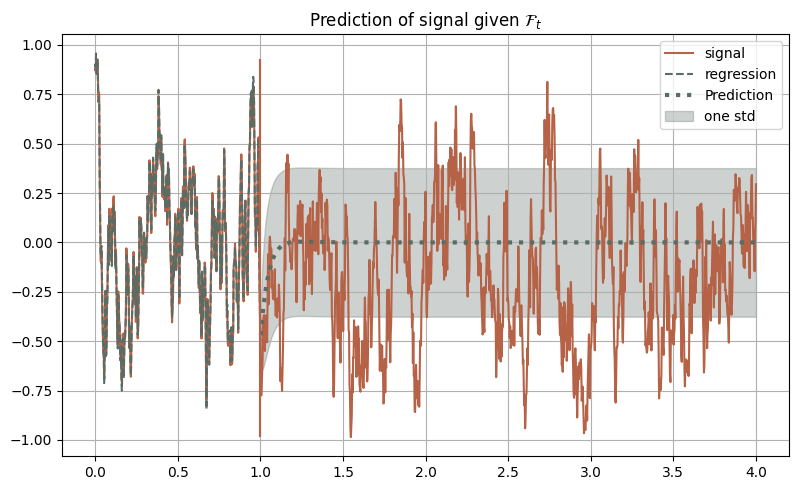

In [42]:
fig, ax = plt.subplots()
ax.plot(t_grid_pos, signal, color=my_copper, label="signal")
ax.plot(t_grid_pos[t_grid_pos <= in_sample_T], (SigS @ l_reg_stat).real[t_grid_pos <= in_sample_T], "--", color=my_green, label="regression")
ax.plot(t_grid_pred, signal_pred, ":", color=my_green, label="Prediction", lw=3)
ax.fill_between(t_grid_pred, signal_pred - signal_pred_std, signal_pred + signal_pred_std, color=my_green, alpha=0.3, label="one std")
ax.vlines(x=in_sample_T, ymin=np.min(signal), ymax=np.max(signal), color=my_copper)
ax.set_title("Prediction of signal given $\mathcal{F}_t$")
ax.legend()

fig.tight_layout()
# fig.savefig("signature_prediction.pdf", format="pdf", transparent=True)